In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
# data 불러오기
file_path_new = 'PM10_fin_2.csv'
data_new = pd.read_csv(file_path_new)


# 변수간의 상관분석

C:\Users\lee seung woo\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


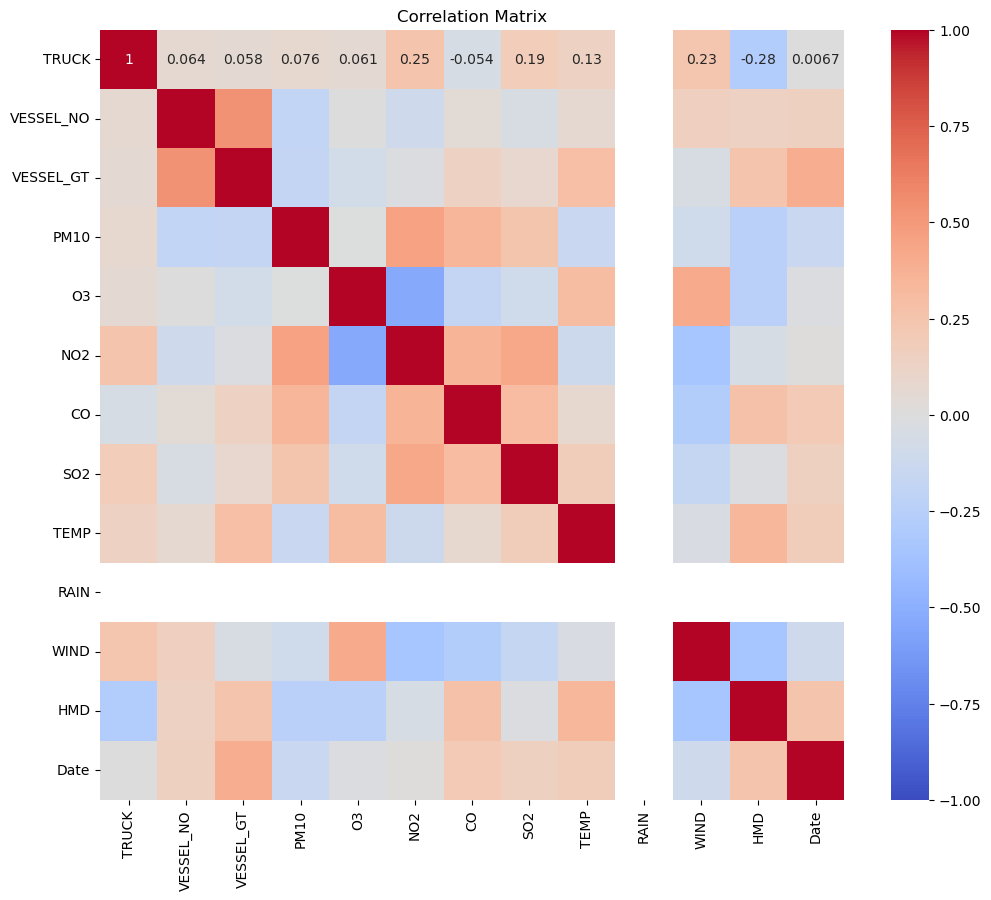

C:\Users\lee seung woo\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


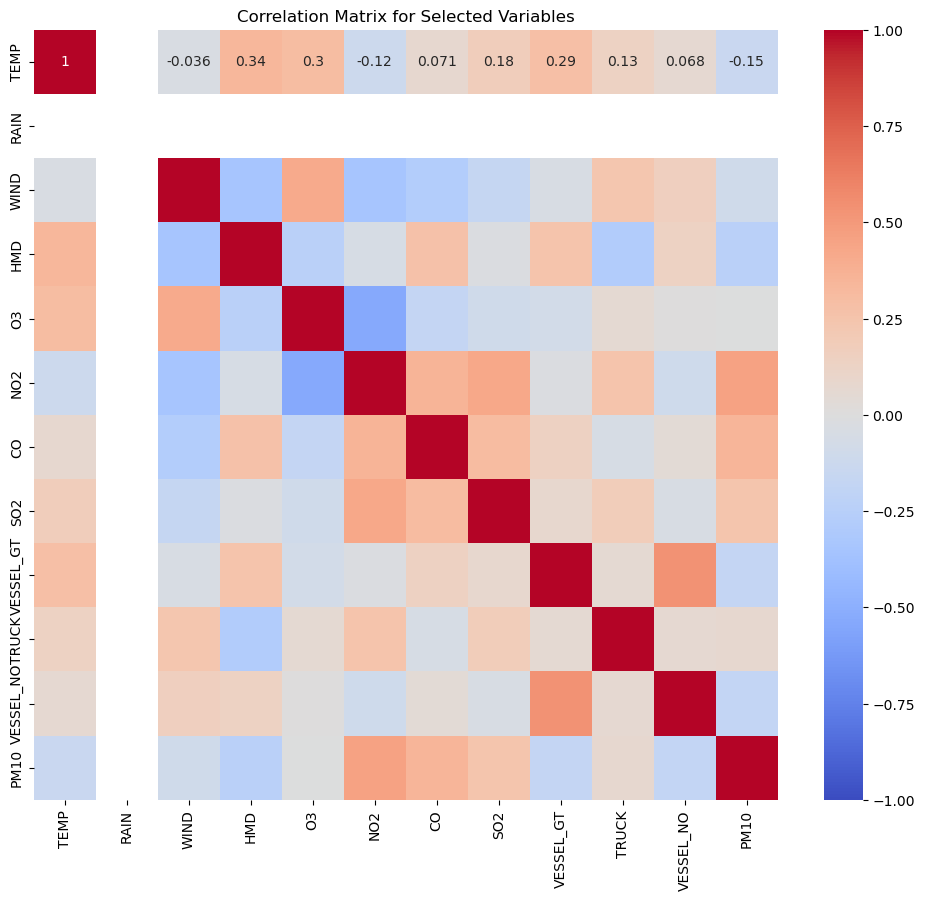

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# datatime으로 변환
data_new['Date'] = pd.to_datetime(data_new['Date'])

# 선형보간법 사용하여 결측치 처리
data_new.interpolate(method='linear', inplace=True)

# IQR 방식을 이용하여 이상치 제거
Q1 = data_new.quantile(0.25)
Q3 = data_new.quantile(0.75)
IQR = Q3 - Q1
data_cleaned = data_new[~((data_new < (Q1 - 1.5 * IQR)) | (data_new > (Q3 + 1.5 * IQR))).any(axis=1)]

# data 정규화
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_cleaned.iloc[:, 1:]), columns=data_cleaned.columns[1:])
data_scaled['Date'] = data_cleaned['Date'].values

# 상관행렬계산
corr_matrix = data_scaled.corr()

# 상관행렬 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# PM10과 다른변수들 상관행렬을 따로 시각화
variables_of_interest = ['TEMP', 'RAIN', 'WIND', 'HMD', 'O3', 'NO2', 'CO', 'SO2', 'VESSEL_GT', 'TRUCK', 'VESSEL_NO', 'PM10']
corr_subset = data_scaled[variables_of_interest].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Selected Variables')
plt.show()



> 상관분석 결과 `NO2`와 `O3`가 `pm10`과 가장 큰 상관관계가 있음을 알 수 있다.

# 데이터 전처리

In [14]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 데이터 불러오기
file_path = 'PM10_fin_2.csv'
data = pd.read_csv(file_path)

# 결측값 확인
print("결측값 대체 전:")
print(data.isnull().sum())

# 결측값 처리 (평균 대체법 사용)
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data.drop(columns=['Date'])), columns=data.columns[1:])

#(결측값이 없어 사실 특별한 조치가 필요하지 않음)

# 이상치 제거 (IQR 방법)
Q1 = data_imputed.quantile(0.25)
Q3 = data_imputed.quantile(0.75)
IQR = Q3 - Q1
data_no_outliers = data_imputed[~((data_imputed < (Q1 - 1.5 * IQR)) | (data_imputed > (Q3 + 1.5 * IQR))).any(axis=1)]

# 이상치 제거 전후 데이터 크기 비교
print(f"이상치 제거 전 데이터 크기: {data_imputed.shape}")
print(f"이상치 제거 후 데이터 크기: {data_no_outliers.shape}")


# 정규화 (평균을 0, 표준 편차를 1로 맞춤)
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_no_outliers), columns=data_no_outliers.columns)

# 정규화 전후 데이터 통계치 비교
print("정규화 전 데이터 통계치:")
print(data_no_outliers.describe())
print("정규화 후 데이터 통계치:")
print(data_scaled.describe())

결측값 대체 전:
Date         0
TRUCK        0
VESSEL_NO    0
VESSEL_GT    0
PM10         0
O3           0
NO2          0
CO           0
SO2          0
TEMP         0
RAIN         0
WIND         0
HMD          0
dtype: int64
이상치 제거 전 데이터 크기: (10239, 12)
이상치 제거 후 데이터 크기: (7682, 12)
정규화 전 데이터 통계치:
             TRUCK    VESSEL_NO     VESSEL_GT         PM10           O3  \
count  7682.000000  7682.000000  7.682000e+03  7682.000000  7682.000000   
mean     42.734054   112.204374  2.217158e+06    29.883111     0.031928   
std      66.297310    16.592048  5.468991e+05    13.796050     0.014328   
min       0.000000    67.000000  7.441270e+05     2.000000     0.000000   
25%       0.000000   100.000000  1.835540e+06    20.000000     0.022000   
50%       3.000000   112.000000  2.198197e+06    27.000000     0.033000   
75%      69.750000   124.000000  2.572595e+06    38.000000     0.041000   
max     252.000000   158.000000  3.743719e+06    70.000000     0.072000   

               NO2           CO   

**각변수마다 갖는 분포가 상이하여 정규화 과정이 필요하다.**

# 모델 학습을 위한 data shape 형성

In [7]:
# Define the window size
#여러 값을 계산해본결과 size를 4로한다.
window_size = 4

# 시퀀스 생성 함수
def create_sequences(data, target, window_size):
    sequences, labels = [], []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        labels.append(target[i + window_size])
    return np.array(sequences), np.array(labels)

# target변수를 분리한다.
features = data_scaled.drop(columns=['PM10'])
target = data_scaled['PM10']

# 시퀀스와 레이블 생성
X, y = create_sequences(features.values, target.values, window_size)

# 시퀀스와 레이블의 크기 확인
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# test size 0.2로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 분할 크기 확인
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# 3D [samples, timesteps, features] 형태로 형성
X_train = X_train.reshape((X_train.shape[0], window_size, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], window_size, X_test.shape[2]))

# 재구성된 데이터 크기 확인
print(f"Reshaped X_train shape: {X_train.shape}")
print(f"Reshaped X_test shape: {X_test.shape}")

X shape: (7678, 4, 11)
y shape: (7678,)
X_train shape: (6142, 4, 11), X_test shape: (1536, 4, 11)
y_train shape: (6142,), y_test shape: (1536,)
Reshaped X_train shape: (6142, 4, 11)
Reshaped X_test shape: (1536, 4, 11)


> 모델학습을 위해 각 데이터에 shape이 일정하게 형성되었음.

# CNN+LSTM 모델사용

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor


In [9]:
# CNN+LSTM 모델을 정의하여 사용한다.
def create_cnn_lstm_model(filters=64, kernel_size=3, neurons=50, learning_rate=0.001):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(window_size, X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        LSTM(neurons, return_sequences=False),  # LSTM 레이어의 출력이 2차원 데이터가 되도록 설정
        Dense(neurons, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae')
    return model



model = KerasRegressor(model=create_cnn_lstm_model, epochs=20, batch_size=16, verbose=0)

# 하이퍼 파라미터 튜닝 

In [ ]:
#CNN+LSTM 모델에 사용할 최적의 파라미터를 계산하기 위해 하이퍼 파라미터튜닝을한다

# the grid search parameters 영역정의
param_grid = {
    'model__filters': [32, 64],
    'model__kernel_size': [2, 3],
    'model__neurons': [50],
    'model__learning_rate': [0.001],
    'batch_size': [16]
}

#  GridSearchCV 를 형성한다
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3)
grid_result = grid.fit(X_train, y_train)

# 최적의 파라미터 결과를 확인
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

> 모델에 학습에 필요한 최적의 파라미터 `batch_size`: 16, `model__filters`: 64, `model__kernel_size`: 3, `model__learning_rate`: 0.001, `model__neurons`: 50

# 평가지표를 계산하기 위한 데이터 역변환

In [18]:
# GridSearchCV를 통해 얻은 최적의 모델활용
best_model = grid_result.best_estimator_.model_
predictions_scaled = best_model.predict(X_test)

# 복원 과정
scaler_features = StandardScaler().fit(features)
scaler_target = StandardScaler().fit(target.values.reshape(-1, 1))

# 정규화된 예측 결과와 실제 타겟 값을 원래 스케일로 복원
predictions = scaler_target.inverse_transform(predictions_scaled.reshape(-1, 1))
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# y_test_original과 predictions의 크기를 출력하여 두 배열의 크기가 일치하는지 확인
print(f"y_test_original shape: {y_test_original.shape}")
print(f"predictions shape: {predictions.shape}")

#두 배열의 길이를 동일하게 맞추기 위해 min_samples를 사용
min_samples = min(len(y_test_original), len(predictions))
y_test_original = y_test_original[:min_samples]
predictions = predictions[:min_samples]

# 평가 지표 계산
mae = mean_absolute_error(y_test_original, predictions)
mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)

print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
y_test_original shape: (1536, 1)
predictions shape: (1536, 1)
MAE: 0.5086854733312571, MSE: 0.4869923344543743, RMSE: 0.6978483606446133
